In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
import math
import re
import warnings

import time
import datetime
from datetime import datetime
from scipy import stats
sns.set()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Set max display columns to max
pd.set_option('display.max_columns', None)

In [2]:
#Pipeline and Grids
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Hyperparameters
from sklearn.model_selection import cross_val_score

#Outliers
from sklearn.ensemble import IsolationForest

#Imputions
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

#Dimenion Reductions
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#Data Preparations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#Ensemble
from sklearn.ensemble import ExtraTreesClassifier

#Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

#Clustering
from sklearn.cluster import KMeans
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice

#Statistic
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
#Word sentiment anylysis
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

[nltk_data] Downloading package punkt to /Users/alicis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/alicis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alicis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
missing_values = ["n/a", "na", "--"]

# Loading data functions

In [5]:
#List of the name that represent the missing value 
missing_values = ["n/a", "na", "--"]

def load_data():
    """ 
    Load boston and seattle dataset.
    
    Returns:
    boston_data: The Airbnb activity in Boston, MA, USA.
    seattle_data: The Airbnb activity in Seattle, WA, USA.
    """
    #Load data and convert missing value to Nan type
    boston_data = pd.read_csv("datasets/boston/listings.csv", na_values = missing_values)
    seattle_data = pd.read_csv("datasets/seattle/listings.csv", na_values = missing_values)
    
    return boston_data, seattle_data

def load_tweet_data():
    """ 
    Load twitter tweets dataset.
    
    Returns:
    merged_tweets: Tweet activity that contains positive and negative tweets.
    
    """
    #Change tweet columns name; To make columns easier to read
    cols = ['sentiment','id','date','query_string','user','text']
    tweet_df = pd.read_csv("datasets/training.1600000.processed.noemoticon.csv",
                            header=None, names=cols, encoding="ISO-8859-1", na_values = missing_values)
    
    #Select the positive and negative tweet data in equal ratio (negative = 0, positive = 4).
    neg_tweets = tweet_df[0:10000]
    pos_tweets = tweet_df[800000:810000]
    
    #Concatenate the negative and postive tweets
    merged_tweets = pd.concat([neg_tweets, pos_tweets], axis=0, join='outer', ignore_index=True, keys=None,
                          levels=None, names=None, verify_integrity=False, copy=True)
    return merged_tweets

def load_sentiment_data(boston_data, seattle_data):
    """ 
    Load user comments and reviews scores from boston and seattle dataset.
    These datasets are prepared for sentiment analysis.
    
    Args:.
    boston_data: dataframe. The Airbnb activity in Boston, MA, USA.
    seattle_data: dataframe. The Airbnb activity in Seattle, WA, USA. 
    
    Returns:
    merged_comments: The dataframe that contains comment and review scores from boston and seattle datasets.
    
    """
    
    cols = ['listing_id','comments']
    #Load data then convert missing value to Nan type
    boston_reviews = pd.read_csv("boston/reviews.csv", usecols=cols, na_values = missing_values)
    seattle_reviews = pd.read_csv("seattle/reviews.csv", usecols=cols, na_values = missing_values)
    
    #Fetch the desired columns
    boston_rating = boston_data[['id','review_scores_rating']]
    seattle_rating = seattle_data[['id','review_scores_rating']]
    
    #Merge two columns with two keys (id and listing id)
    boston_merged_comments = pd.merge(boston_rating, boston_reviews, 
                                      left_on='id', right_on='listing_id', how='left').drop('listing_id', axis=1)
    seattle_merged_comments = pd.merge(seattle_rating, seattle_reviews, 
                                      left_on='id', right_on='listing_id', how='left').drop('listing_id', axis=1)
    
    #Concatenate boston and seattle rows
    merged_comments = pd.concat([boston_merged_comments, seattle_merged_comments], axis=0, join='outer', 
                                ignore_index=True, keys=None, levels=None, names=None, verify_integrity=False, copy=True)
    
    #Drop missing values then reset the df index
    merged_comments = merged_comments.dropna()
    merged_comments.reset_index(inplace=True,drop=True)
  
    return merged_comments

# Standard Cleaning functions

In [6]:
def drop_unbalanced_ratio(df):
    """ 
    Drop low diversity or too high diversity columns:
    Drop column that has an unbalanced unique value ratio (one unique value or excessive unique values).
    
    Notes:
    One unique value or excessive unique values columns doesn't give a decent analysis because 
    it doesn't provide meaningful informaiton.
    
    Args:
    df: dataframe. The pandas dataframe.
    
    Returns:
    cleaned_data: The dataframe that dropped column that has one unique value or excessive unique values.
    
    """
    data = df.copy()
    count_unique_col= []
    num_feats = data.select_dtypes(include='number')
    # Drop column that has only one unique value
    ### For numeric variables
    # Check by using standard deviation (if std != 0 then drop)
    if len(num_feats.columns[num_feats.std()==0]) != 0:
        data = data.drop(num_feats.columns[data.std()==0],axis=1)
            
    ### For categorical variables
    if len(data.select_dtypes(exclude='number')):
        # The number of unique values in each columns
        # datetime_is_numeric to slience the change of datetime type in the future warning
        unique_val = data.describe(include='all', datetime_is_numeric=True).loc['unique']
        # The number of values in each columns
        count_val = data.describe(include='all', datetime_is_numeric=True).loc['count']    

        # Remove the columns that contain one unique value or 
        # The column that have unique variables equal to the number of values. (Too much unqiue value in one column)
        for idx, val in enumerate(unique_val):
            if unique_val[idx] == count_val[idx] or unique_val[idx] == 1:
                count_unique_col.append(unique_val.index[idx])
            
    # Drop the columns that contain one unique value or excessive unique value
    cleaned_data = data.drop(count_unique_col,axis=1)
    # Show Dropped columns 
    if len(count_unique_col):
        print("Dropped unbalanced ratio columns:")
        print (count_unique_col)

    return cleaned_data

def string2bool(df):
    """ 
    Convert column that has likely boolean string to boolean.
    
    Args:
    df: dataframe. The pandas dataframe.
    
    Returns:
    merged_df: The dataframe after converted column that has likely boolean string to boolean.
    
    """
    
    # Select categorical columns
    non_num_feats = df.select_dtypes(exclude=['number','bool']).copy()
    # Select numeric columns
    num_feats = df.select_dtypes(include='number').copy()

    print ("\nConverted boolean string to boolean type:")

    for col_name in non_num_feats.columns:
        # Select a serie from iteration the column name
        tmp_serie = non_num_feats[col_name].dropna()
        # Find the unique value names from above serie
        unique_set = set(tmp_serie.value_counts().index.str.lower())
        # Map boolean
        if unique_set == {'t','f'}:
            non_num_feats.loc[:, col_name] = non_num_feats.loc[:, col_name].map({'t': True, 'f': False})
            print (col_name)
        elif unique_set == {'true','false'}:
            non_num_feats.loc[:, col_name] = non_num_feats.loc[:, col_name].map({'true': True, 'false': False})
            print (col_name)

    # Combine numeric_features and non_num_features
    merged_df = pd.concat([non_num_feats, num_feats], axis=1)
    
    return merged_df

def remove_spl_char(df):
    """ 
    Remove special characters.
    
    Args:
    df: dataframe. The pandas dataframe.
    
    Returns:
    data: The removed special characters dataframe.
    
    """
    
    print("\nRemoving special character...")
    
    data = df.copy()
    # Regex: string must contain at least one ,.$% and contains only 0-9,.$%
    pattern = re.compile("^(?=^[0-9,.$%]+$)(?=.*?[,.$%]).+$")
    for col_name in data.columns:
        if data[col_name].dtype == "object":
            # Remove the text that contains only special character.
            data[col_name].replace(r"^[^A-Za-z0-9]+$", np.nan, regex=True, inplace=True)
            if data[col_name].str.match(pattern).all():
                # Replace the text that not contain A-Za-z0-9. characters
                data[col_name].replace(r"[^A-Za-z0-9.]+", "", regex=True, inplace=True)
                # Convert object dtype (that has numeric value inside)to numeric dtype
                data[col_name] = pd.to_numeric(data[col_name])
                #Store columns name
                print(col_name)
            else:
                # Replace the text that not contain A-Za-z0-9 ^,!?.\/ characters 
                data[col_name].replace(r"[^A-Za-z0-9 ^,!?.\/'+]", "", regex=True, inplace=True)
                    
    return data

def abnormal_str2nan(df):
    """ 
    Replace one character in stirng to missing value (NaN).
    
    Args:
    df: dataframe. The pandas dataframe.
    
    Returns:
    data: The dataframe after repalce abnormal strings to NaN.
    
    """
    data = df.copy()
    # Remove the columns that has only one character
    for col_name in data.columns:
        data.replace("^.{0,1}$", np.nan, regex=True, inplace=True)
    return data

def string2date(df):
    """ 
    Convert likely date string to date type.
    
    Note: 
    This function creates NaT value. Proceed with Caution!
    
    Args:
    df: dataframe. The pandas dataframe.
    
    Returns:
    data: The dataframe after converted likely date string to date type.
    
    """
    data = df.copy()
    
    print('\nCoverting date string to date type...')
    
    #Set Regex date format
    pattern = re.compile(r"\d{4}-\d{2}-\d{2}")
    
    for col_name in data.columns:
        if data[col_name].dtype == "object":
            if data[col_name].str.match(pattern).all():
                print(col_name)
                # Convert date string to date type format: %Y%m%d
                data.loc[:, col_name] = pd.to_datetime(data.loc[:, col_name], format='%Y-%m-%d', errors='coerce')
    return data

def standard_data_cleansing(df, target_name, nan_threshold = 0.75):
    """ 
    Standard data cleansing process.
    
    Args:
    df: dataframe. The pandas dataframe.
    target_name: string. The target column name.
    nan_threshold: float. The NaN ratio threshold that do not allows in one column.
    
    Returns:
    standard_cleaned_df: The cleaned dataframe after performed standard cleaning process.
    
    """
    # Filter out ID and URL columns
    data = df.loc[:, ~df.columns.str.contains('id|url')].copy()
    
    print ('Dropped url and id columns: ')
    print (df.loc[:, df.columns.str.contains('id|url')].columns.values)

    # Drop column that has an unbalanced unique value ratio
    unique_filtered = drop_unbalanced_ratio(data)

    # Transform boolean string to boolean type
    cleared_bool= string2bool(unique_filtered)

    # Date string to Datetime type
    converted_date = string2date(cleared_bool)

    # Remove abnormal string that has only one character
    df = abnormal_str2nan(converted_date)                       

    # Remove special character in DataFrame
    cleaned_df = remove_spl_char(df)
    
    # Drop the column that has missing values more than the percentage threshold
    mis_columns = cleaned_df.columns[cleaned_df.isnull().mean()>nan_threshold]
    cleaned_df.drop(mis_columns, axis=1, inplace=True)
    
    #Remove missing values in label/target column
    standard_cleaned_df = cleaned_df.dropna(subset=[target_name],axis=0).copy()
    
    #Reset index
    standard_cleaned_df.reset_index(drop=True, inplace=True)
    
    print('\n Dropped the columns that contains missing value > ', (1-nan_threshold)*100,'%: ')
    print(list(mis_columns))
    
    return standard_cleaned_df

# Filtering outier funcitons

In [7]:
def z_outlier_filter(df):
    """ 
    Filter outlier by statistic z score.
    
    Args:
    df: dataframe. The pandas dataframe that must contain only numeric values in each column.
    
    Returns:
    filtered_df: The removed outlier dataframe by using z score.
    
    """
    data = df.copy()
    
    #Calculate z-scores
    z_scores = stats.zscore(data)
    abs_z_scores = np.abs(z_scores)
    
    #set NaN to 0
    abs_z_scores[np.isnan(abs_z_scores)] = 0

    #STD method
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    filtered_df = data[filtered_entries]
    return filtered_df

def ML_outlier_filter(df):
    """ 
    Filter by modeling(ML:isolationForest) instead of statistic z method.
    
    Args:
    df: dataframe. The pandas dataframe that must contain only numeric values in each column.
    
    Returns:
    anomaly_solved: The removed outlier dataframe by using machine learning (isolationForest).
    
    """
    data = df.copy()
    # Define classifier
    clf = IsolationForest(max_samples=100, random_state = 42, contamination= 'auto')
    data['anomaly'] = clf.fit_predict(data)
    
    # Select the datapoint that not abnormal
    anomaly_solved = data[data['anomaly'] == 1]
    anomaly_solved = anomaly_solved.drop('anomaly',axis=1)
    return anomaly_solved

def remove_outlier(df):
    """ 
    Remove the outliers

    Args:
    df: dataframe. The pandas dataframe that needs to remove outlier.
    
    Returns:
    removed_outlier_df: The removed outlier dataframe
    
    """
    features = df.copy()
    
    # Separate numeric and non-numeric columns/features
    # To make it simpler when dealing with outlier
    numeric_feats = features.select_dtypes(include='number')
    non_num_feats = features.select_dtypes(exclude='number')
    
    # Detect NaN to determine whether data is propriate with machine learning outlier removing functions or not
    if len(numeric_feats.columns[numeric_feats.isnull().any()]):
        # Remove outlier by statistic z score method
        anomaly_solved = z_outlier_filter(numeric_feats)
    else:
        # Remove outlier by statistic z score method
        z_anomaly_solved = z_outlier_filter(numeric_feats)
        
        # Remove outlier by ML_outlier_filter method (Manchine Learning)
        anomaly_solved = ML_outlier_filter(z_anomaly_solved)
        
    # Combine numeric features and catergorical features
    non_num_feats_df = pd.DataFrame(non_num_feats,index = anomaly_solved.index)
    removed_outlier_df = pd.concat([non_num_feats_df, anomaly_solved], axis=1)

    # Reset index after drop columns
    removed_outlier_df.reset_index(drop=True, inplace=True)
    
    return removed_outlier_df

# Randomforest 

In [8]:
# Randomsearch vs Gridsearch
#https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85
def rf_best_para(features, label, cross_v):
    """ 
    Find random forest best parameters
    
    Args:
    features: dataframe. The features pandas dataframe.
    label: dataframe series. The target series.
    cross_v: int, The number of cross validation fold.
    
    Returns:
    rf_random: Random forest model with optimize parameters.
    
    """
    #Define randomforest hyperparameters

    # Create the random grid
    param_grid = {'n_estimators': [100,150,200,300], # Number of trees in random forest
                  'max_features': ['auto','sqrt'], # Number of features to consider at every split
                  'max_depth': [18,20,22], # Maximum number of levels in tree
                  'min_samples_split': [1,3,5], # Minimum number of samples required to split a node
                  'min_samples_leaf': [1,2,3], # Minimum number of samples required at each leaf node
                  'bootstrap': [True, False],
                  'random_state': [42]} # Method of selecting samples for training each tree
    
    # Switch between classifier and Regressor according to target dtype
    if label.dtype == 'object':
        rf = RandomForestClassifier()
    else:
        rf = RandomForestRegressor()

    # Perform the random grid and cross-validation to search for best hyperparameters
    # Search across 100 different combinations, and use all available cores
    optimized_rf = GridSearchCV(estimator = rf, param_grid=param_grid, cv = cross_v, verbose=cross_v, n_jobs = -1)
    # Fit the opimize rf model
    optimized_rf.fit(features, label)
    print(optimized_rf.best_params_)
    
    return optimized_rf

def evaluate(model, test_features, test_labels):
    """ 
    Evaluate model by calculating accuracy from standrad mean errors (SME).
    
    Args:
    model: object. The model object.
    test_features: dataframe. The feature pandas dataframe.
    test_labels: dataframe. The label/target pandas dataframe.
    
    Returns:
    accuracy: The accuracy of model.
    
    """
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

def rf_predict(features, label, drop_cols = []):
    """ 
    Predict target column by using randomforest model
    
    Args:
    optimize_model: model. The model after optimize hyperparameters
    features: dataframe. The feature pandas dataframe.
    label: dataframe series. The target series.
    drop_cols: string. The column name that you want to drop before predicting.
    
    """
    X = features.copy()
    y = label.copy()
    
    #Split into train and test
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
    
    optimized_rf = rf_best_para(X_train, y_train, rf_hyperparameters(), 3)

    #Standard RF Model Performance
    base_model = RandomForestRegressor(random_state = 42)
    base_model.fit(X_train, y_train)
    base_accuracy = evaluate(base_model, X_test, y_test)
    
    #Apply optimize hyperparameters to RF model
    #Optimize RF Model Performance
    print ('\nOptimize RF Model Performance')
    best_rf = rf_random.best_estimator_
    rf_accuracy = evaluate(best_rf, X_test, y_test)

# Feature selection

In [9]:
def remove_high_corr(df, threshold = 0.75):
    """ 
    Remove high correlation columns.
    
    Args:
    df: dataframe. The pandas dataframe.
    threshold: float. The correlation threshold that used to drop high correlation columns.
    
    Returns:
    removed_high_corr: The dataframe after removed high correation columns.
    
    """    
    
    # Separate numeric and non-numeric columns/features
    # To make it simpler when dealing with outlier
    numeric_feats = df.select_dtypes(include='number').copy()
    non_num_feats = df.select_dtypes(exclude='number').copy()
    
    # Intialize correation for dataframe
    corr = numeric_feats.corr()
    # To make sure while loop does not perform infinite loops when problems occur.
    j=0
    print ('Dropped high correlation column: ')
    # In each while loop, drop columns that have a high correlation (set by threshold) with others.
    # Then drop columns again until all columns doesn't have high correlation with other columns
    while (j < len(numeric_feats.columns)):
        # Loop for each feature correlation
        for corr_col in corr.columns:
            # the not drop count (total not-drop activities)
            not_drop = 0
            corr_len = len(corr.columns)
            # Get the feature correlation list 
            corr = numeric_feats.corr()
            corr_target = abs(corr.loc[:,corr_col])
            # Select the features that have correlation > threshold
            relevant_features = corr_target[corr_target>threshold]
            # Drop itself
            relevant_features.drop(labels=corr_col, inplace=True)
            
            # If correlation > threshold features exist then
            if relevant_features.index.values.shape[0] > 0:
                # Drop features that have correlation > threshold
                numeric_feats.drop(relevant_features.index.values,axis=1, inplace=True)
                # Show dropped features
                print (relevant_features.index.values)
            # The feature correations after drop or not drop features
            update_corr = numeric_feats.corr()
            # If the dropping of the correlation > threshold features occur then break the inner loop and calculate correlation again after break (inside new for loop)
            if len(update_corr.columns) != corr_len:
                break
            not_drop +=1
        # Break outter loop if features that correlation > threshold aren't dropped
        if not_drop == corr_len:
            break
        j+=1
        
    # Combine numeric features and catergorical features
    non_num_feats_df = pd.DataFrame(non_num_feats,index = numeric_feats.index)
    #merged_feats = pd.concat([non_num_feats_df, numeric_feats], axis=1)
    merged_feats = pd.concat([non_num_feats_df, numeric_feats], axis=1)
    # Drop column that has an unbalanced unique value ratio
    removed_high_corr = drop_unbalanced_ratio(merged_feats)
    
    # Reset index after drop columns
    removed_high_corr.reset_index(drop=True, inplace=True)
    
    return removed_high_corr

def rf_feature_selection(optimized_model, features, label, cross_v):
    """ 
    Perform RandomForest feature selection.
    
    Notes:
    if categorical data presents in your dataframe, you must convert to one-hot encoding before assign that dataframe.
    
    Args:
    optimize_model: model. The model after optimize hyperparameters
    features: dataframe. The feature pandas dataframe.
    label: dataframe series. The target series.
    
    Returns:
    feat_importances: The series of feature names and their importances in percentage.
    
    """
    X = features.copy()
    y = label.copy()
    
    # Find the optimize model by randomgridsearch
    #rf_model = optimized_model
    #rf_model.fit(X,y)
    
    #Show feature_importances_ by using inbuilt class feature_importances of tree based classifiers
    #print(model.feature_importances_)
    
    #Plot graph of feature importances for better visualization
    feat_importances = pd.Series(optimized_model.best_estimator_.feature_importances_, index=X.columns)
    feat_importances.nlargest(16).plot(kind='barh',figsize=(20,10))
    plt.show()
    
    print ('Top 20 Selected features: ')
    print (feat_importances.nlargest(20))
    
    return feat_importances

def feat_selection_percentage(df, features_importances, threshold = 0.99):
    """ 
    Perform feature selection by accumulating(descending) the importance of features until the number meets the threshold.
    The unselected features, in the accumulation process, are dropped.
    
    Args:
    df: dataframe. The feature pandas dataframe.
    features_importances: series. The list of feature names and their importances in percentage.
    threshold: float. The percentage accumulating threshold.
    
    Returns:
    selected_features: The selected feature dataframe.
    
    """
    features = df.copy()
    #Descending accumulation
    feat_importances = features_importances.sort_values(ascending = False).copy()
    col_name = pd.DataFrame(columns = ['name'])
    importances = 0
    for idx in range(len(feat_importances)):
        #Accumulate Add up importance value(percentage)
        importances += feat_importances[idx]
        #Keep importance feature in col_name
        col_name.loc[idx] = feat_importances.index[idx]
        if importances >= threshold:
            break
    selected_features = features[col_name['name']]
    return selected_features

In [10]:
def list_dummies(df, col_name, drop=False):
    """ 
    Create dummies from the list of items
    
    Args:
    df: dataframe. The pandas dataframe.
    col_name: string or list(string). The column name: The column that each value contains the list of items.
    
    Returns:
    Dummies_dataframe: The dataframe contains the dummy columns.
    
    """
    data = df.copy()
    
    for col in col_name:
        # Remove ' and space from the texts
        data[col].replace(r"[' ]", "", regex=True, inplace=True)
        # Split the string by , to the list of strings
        data[col] = data[col].str.split(',')
        # Create dummies from stack then sum it to 1 dimension
        data_dummies = pd.get_dummies(data[col].apply(pd.Series).stack()).sum(level=0)
        # Combine dummies and current dataframe together
        data = pd.concat([data, data_dummies], axis=1)
    if drop:
        data.drop(col_name, axis=1, inplace=True)
        
    return data 

def pearsoncorr_plot(df, size_x = 40, size_y = 35):
    """ 
    Plot pearson's correlation
    
    Args:
    df: dataframe. The feature pandas dataframe.
    size_x: int. The size of x line.
    size_y: int. The size of y line.
    
    """
    #Using Pearson Correlation
    plt.figure(figsize=(size_x,size_y))
    cor = df.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()

# Loading dataset

### Boston

In [11]:
# Load the Boston data
raw_boston_data = pd.read_csv("datasets/boston/listings.csv", na_values = missing_values)

### Seattle

In [12]:
# Load the Seattle data
raw_seattle_data = pd.read_csv("datasets/seattle/listings.csv", na_values = missing_values)

# 1st question : What factors affect price fluctuations?

# Cleaning dataset
neighbourhood: much na

In [13]:
# Drop unused columns 
boston_cols = ['name','summary','space','description','neighborhood_overview','notes','transit','access','interaction', # String require NLP
               'house_rules','host_about',# String require NLP
               'latitude','longitude','host_name', # Not meaningful
               'street', 'city','host_location', 'smart_location','host_acceptance_rate', 'host_response_rate', 
               'availability_30','availability_60','availability_90','availability_365',
               'host_listings_count', 'host_total_listings_count','calculated_host_listings_count','minimum_nights','maximum_nights', # Unbalanced unique value (One unqiue value dominates other unique value in the number)
               'neighbourhood', # Duplicate
               'host_verifications', 'amenities', # Candidates
               'host_response_time', # Decrease the accuarcy but high NaN
               'cleaning_fee','extra_people','security_deposit','guests_included', # Directly connect with price ($ dollars)
               'accommodates','beds','bedrooms','bathrooms', # Directly connect with price (price increase these value increase)
               'calendar_updated','host_since','first_review','last_review', # I will not use to analyse here
               'review_scores_rating','review_scores_value','number_of_reviews','reviews_per_month','review_scores_accuracy'] # Remove total review scores because they have high relation with other undrop review score
boston_data = raw_boston_data.drop(boston_cols, axis=1)

In [14]:
# Cleaning by standard data cleansing 
cleaned_boston = standard_data_cleansing(boston_data, 'price')
cleaned_boston.head()

Dropped url and id columns: 
['id' 'listing_url' 'scrape_id' 'thumbnail_url' 'medium_url' 'picture_url'
 'xl_picture_url' 'host_id' 'host_url' 'host_thumbnail_url'
 'host_picture_url' 'host_identity_verified']
Dropped unbalanced ratio columns:
['last_scraped', 'experiences_offered', 'state', 'country_code', 'country', 'calendar_last_scraped', 'requires_license']

Converted boolean string to boolean type:
host_is_superhost
host_has_profile_pic
is_location_exact
instant_bookable
require_guest_profile_picture
require_guest_phone_verification

Coverting date string to date type...

Removing special character...
price
weekly_price
monthly_price

 Dropped the columns that contains missing value >  25.0 %: 
['weekly_price', 'monthly_price', 'neighbourhood_group_cleansed', 'square_feet', 'has_availability', 'license', 'jurisdiction_names']


,host_is_superhost,host_neighbourhood,host_has_profile_pic,neighbourhood_cleansed,zipcode,market,is_location_exact,property_type,room_type,bed_type,price,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location
0,False,Roslindale,True,Roslindale,02131,Boston,True,House,Entire home/apt,Real Bed,250.0,False,moderate,False,False,NaN,NaN,NaN,NaN
1,False,Roslindale,True,Roslindale,02131,Boston,True,Apartment,Private room,Real Bed,65.0,True,moderate,False,False,9.0,10.0,10.0,9.0
2,True,Roslindale,True,Roslindale,02131,Boston,True,Apartment,Private room,Real Bed,65.0,False,moderate,True,False,9.0,10.0,10.0,9.0
3,False,NaN,True,Roslindale,NaN,Boston,False,House,Private room,Real Bed,75.0,False,moderate,False,False,10.0,10.0,10.0,10.0
4,True,Roslindale,True,Roslindale,02131,Boston,True,House,Private room,Real Bed,79.0,False,flexible,False,False,10.0,10.0,10.0,9.0


## Remove outlier

In [15]:
cleaned_df = cleaned_boston.dropna(axis=0)

In [16]:
removed_outlier = remove_outlier(cleaned_df)
removed_outlier.head()

,host_is_superhost,host_neighbourhood,host_has_profile_pic,neighbourhood_cleansed,zipcode,market,is_location_exact,property_type,room_type,bed_type,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,price,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location
0,False,Roslindale,True,Roslindale,02131,Boston,True,Apartment,Private room,Real Bed,True,moderate,False,False,65.0,9.0,10.0,10.0,9.0
1,True,Roslindale,True,Roslindale,02131,Boston,True,Apartment,Private room,Real Bed,False,moderate,True,False,65.0,9.0,10.0,10.0,9.0
2,True,Roslindale,True,Roslindale,02131,Boston,True,House,Private room,Real Bed,False,flexible,False,False,79.0,10.0,10.0,10.0,9.0
3,True,Roslindale,True,Roslindale,02131,Boston,True,Condominium,Private room,Real Bed,False,flexible,False,False,75.0,10.0,10.0,10.0,9.0
4,False,Roslindale,True,Roslindale,02131,Boston,False,Apartment,Entire home/apt,Real Bed,False,strict,False,False,100.0,10.0,10.0,10.0,9.0


In [17]:
removed_outlier.shape

(1469, 19)

# Feature selection

## Pearson's correlation

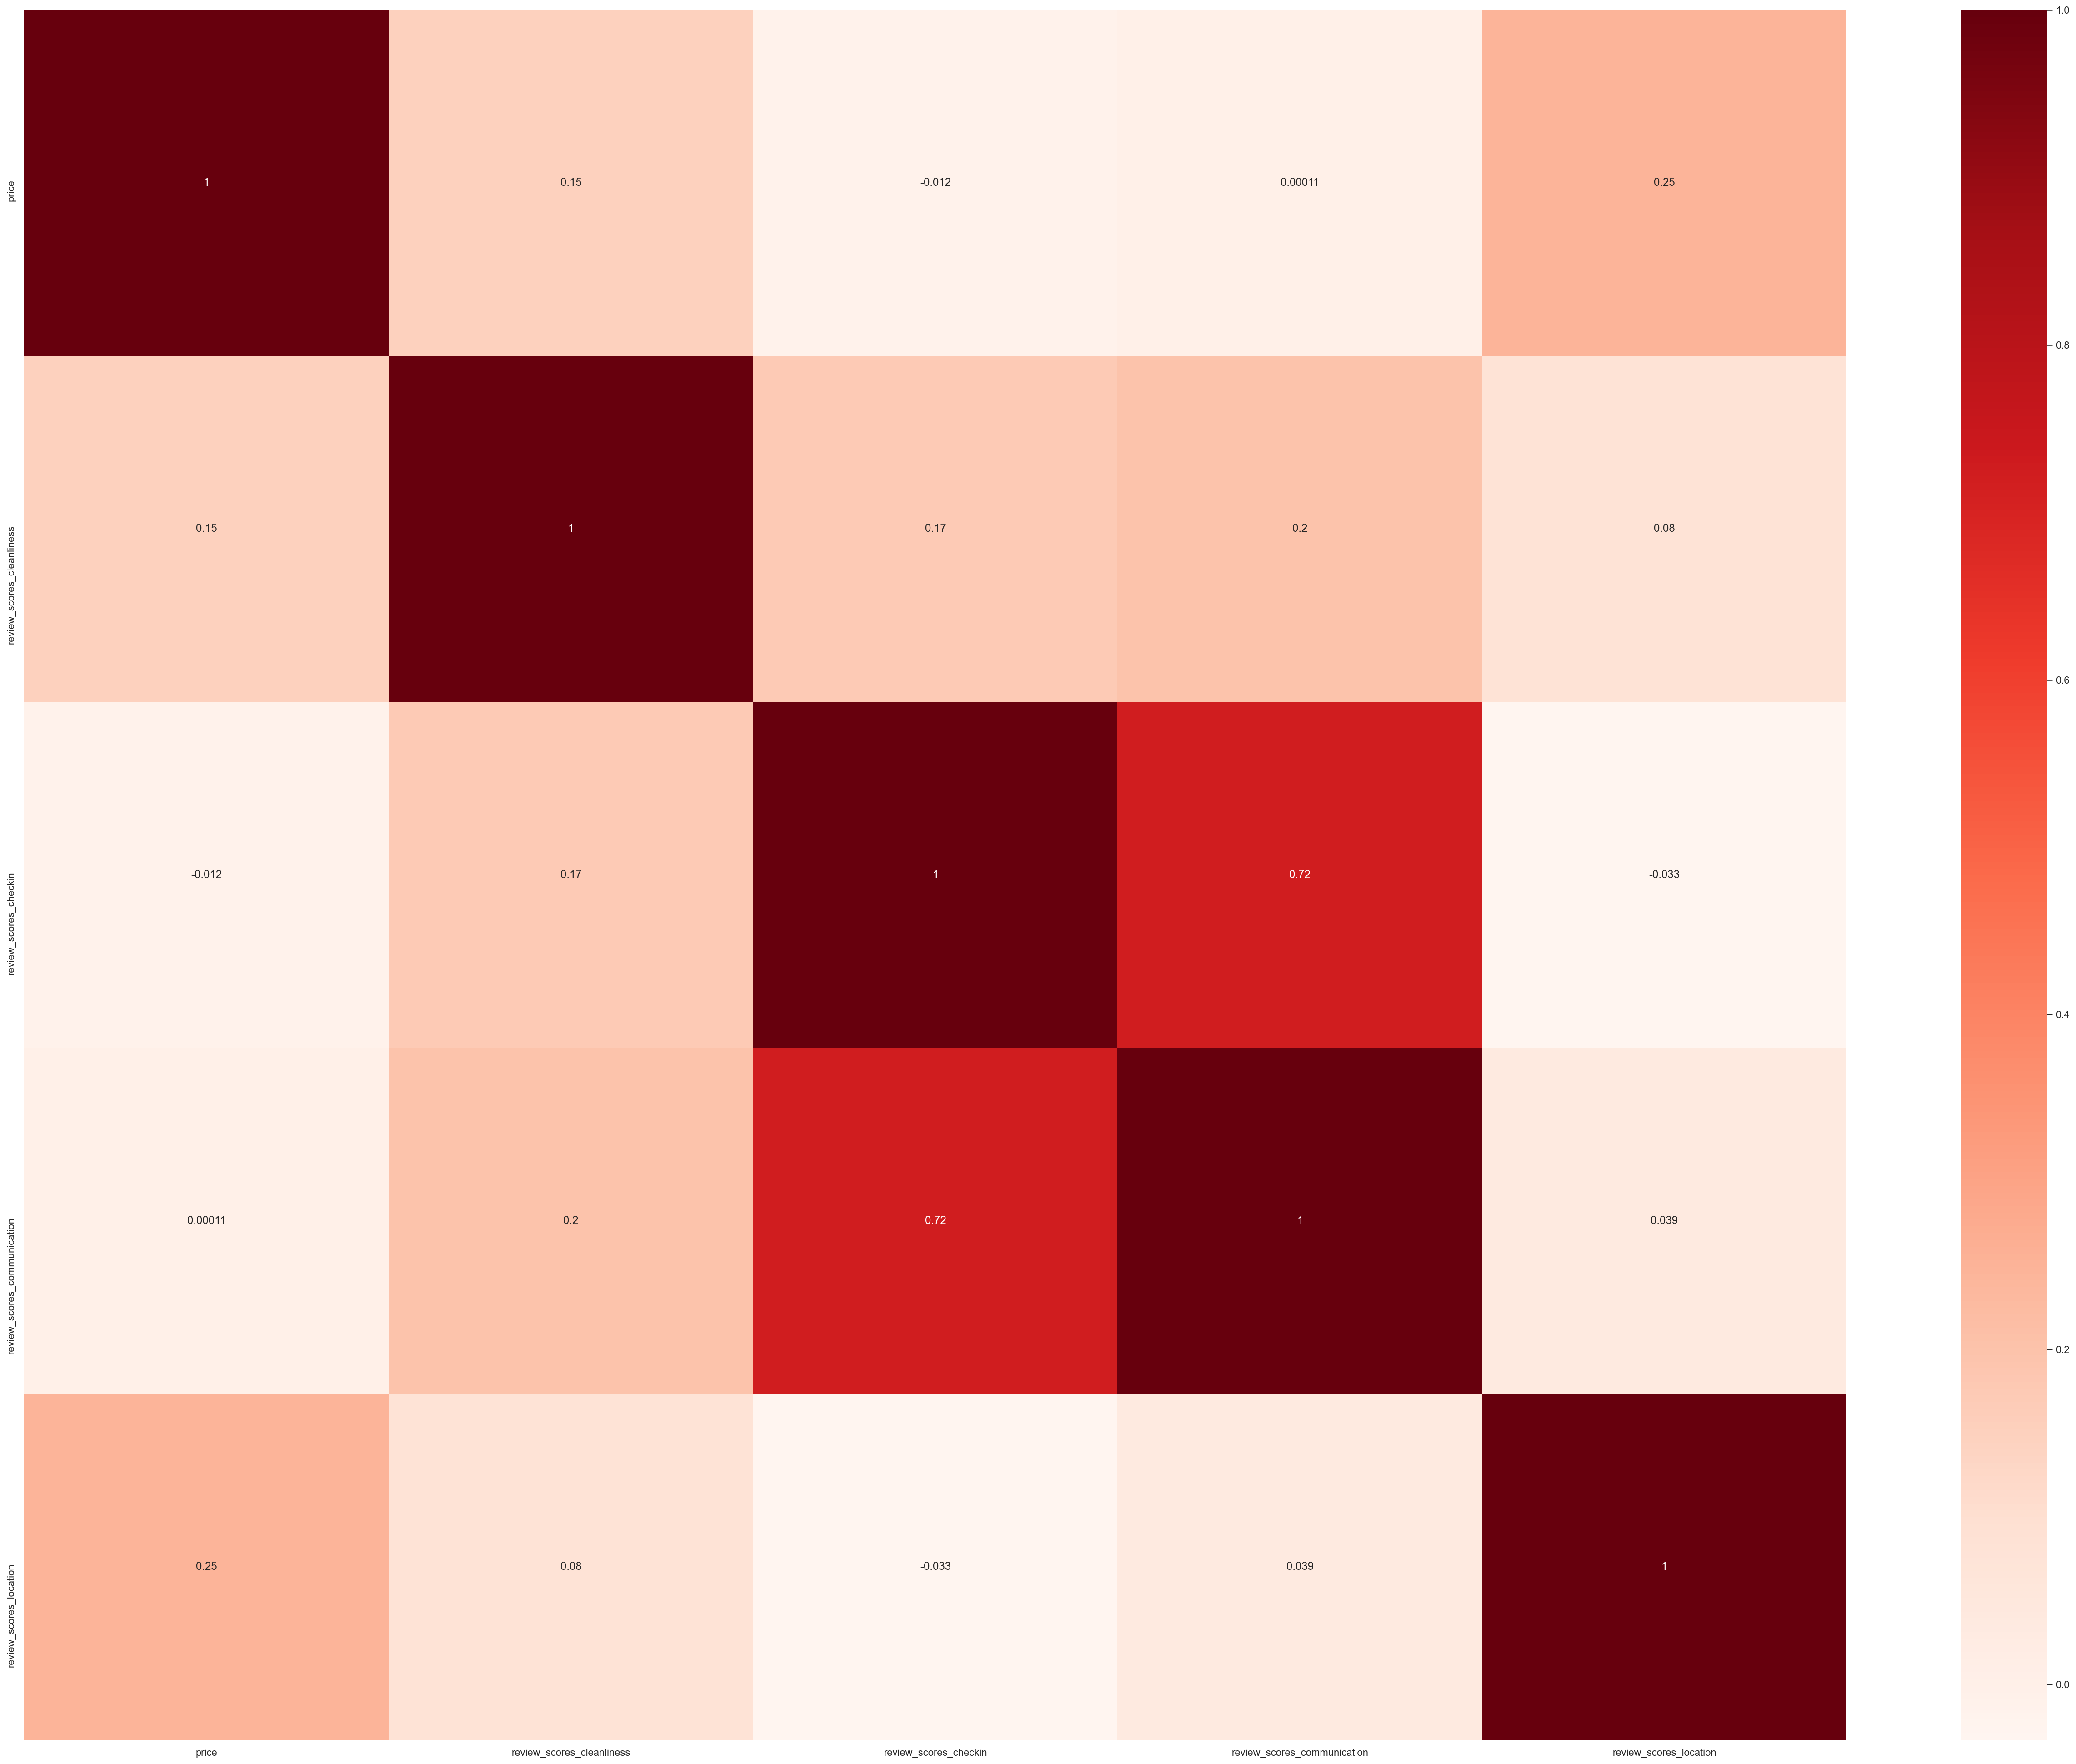

In [18]:
# Show column correlations
pearsoncorr_plot(removed_outlier.select_dtypes(include='number'))

In [19]:
filtered_features = remove_high_corr(removed_outlier, 0.75)
filtered_features.shape

Dropped high correlation column: 


(1469, 19)

## Random forest (Machine Learning)

### Create dummies for categorical values

In [20]:
# Drop the target
X_features = filtered_features.drop('price', axis = 1)

#if categorical data presents in your dataframe, you must convert to one-hot encoding before assign that dataframe.
# Create dummies from the list of items
#dummies_df = list_dummies(X_features, ['host_verifications','amenities'], drop=True)

# Add dummies to DataFrame (categorical data)
dummies_data = pd.get_dummies(X_features,prefix_sep='_', dummy_na=False)
# Remove space ' ' and place it with '_' to make it easiler to analyse data
dummies_data.columns = dummies_data.columns.str.replace(' ', '_')

In [21]:
dummies_data.head()

,host_is_superhost,host_has_profile_pic,is_location_exact,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,host_neighbourhood_AllstonBrighton,host_neighbourhood_Back_Bay,host_neighbourhood_Beacon_Hill,host_neighbourhood_Bernal_Heights,host_neighbourhood_Brookline,host_neighbourhood_Cambridge,host_neighbourhood_Central_Business_District,host_neighbourhood_Charlestown,host_neighbourhood_Chestnut_Hill,host_neighbourhood_Chinatown,host_neighbourhood_Coolidge_Corner,host_neighbourhood_Coral_Way,host_neighbourhood_Dorchester,host_neighbourhood_Downtown,host_neighbourhood_Downtown_Crossing,host_neighbourhood_East_Boston,host_neighbourhood_Fenway/Kenmore,host_neighbourhood_Financial_District,host_neighbourhood_Flatiron_District,host_neighbourhood_Gay_Village,host_neighbourhood_Harvard_Square,host_neighbourhood_Hyde_Park,host_neighbourhood_Jamaica_Plain,host_neighbourhood_Leather_District,host_neighbourhood_Malden,host_neighbourhood_Mattapan,host_neighbourhood_Medford,host_neighbourhood_Mission_District,host_neighbourhood_Mission_Hill,host_neighbourhood_Newton,host_neighbourhood_North_End,host_neighbourhood_Roslindale,host_neighbourhood_Roxbury,host_neighbourhood_Somerville,host_neighbourhood_South_Boston,host_neighbourhood_South_End,host_neighbourhood_Theater_District,host_neighbourhood_Upper_East_Side,host_neighbourhood_West_End,host_neighbourhood_West_Roxbury,host_neighbourhood_Winthrop,neighbourhood_cleansed_Allston,neighbourhood_cleansed_Back_Bay,neighbourhood_cleansed_Bay_Village,neighbourhood_cleansed_Beacon_Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East_Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde_Park,neighbourhood_cleansed_Jamaica_Plain,neighbourhood_cleansed_Leather_District,neighbourhood_cleansed_Longwood_Medical_Area,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission_Hill,neighbourhood_cleansed_North_End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South_Boston,neighbourhood_cleansed_South_Boston_Waterfront,neighbourhood_cleansed_South_End,neighbourhood_cleansed_West_End,neighbourhood_cleansed_West_Roxbury,zipcode_02108,zipcode_02109,zipcode_02110,zipcode_02111,zipcode_02113,zipcode_02114,zipcode_02115,zipcode_02116,zipcode_02118,zipcode_02119,zipcode_02120,zipcode_02121,zipcode_02122,zipcode_02124,zipcode_02125,zipcode_02126,zipcode_02127,zipcode_02128,zipcode_02129,zipcode_02130,zipcode_02131,zipcode_02132,zipcode_02134,zipcode_02135,zipcode_02136,zipcode_02141,zipcode_02145,zipcode_02163,zipcode_02210,zipcode_02215,zipcode_02445,zipcode_02446,zipcode_02467,market_Boston,market_Other_Domestic,market_San_Francisco,property_type_Apartment,property_type_Bed__Breakfast,property_type_Boat,property_type_Condominium,property_type_Dorm,property_type_Entire_Floor,property_type_Guesthouse,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,property_type_Villa,room_type_Entire_home/apt,room_type_Private_room,room_type_Shared_room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pullout_Sofa,bed_type_Real_Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_superstrict30
0,False,True,True,True,False,False,9.0,10.0,10.0,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
1,True,True,True,False,True,False,9.0,10.0,10.0,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1

In [22]:
dummies_data.shape

(1469, 136)

### Declare X and y

In [23]:
# Declare X(features), y(target)
X = dummies_data  # Independent columns
y = filtered_features['price']   # Dependent column

### Optimizing hyperparameters

In [24]:
# Optimizing hyperparameters
optimized_rf = rf_best_para(X, y, 5)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  3.1min finished


{'bootstrap': True, 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42}


### Find varible that related with price by the importance of feature

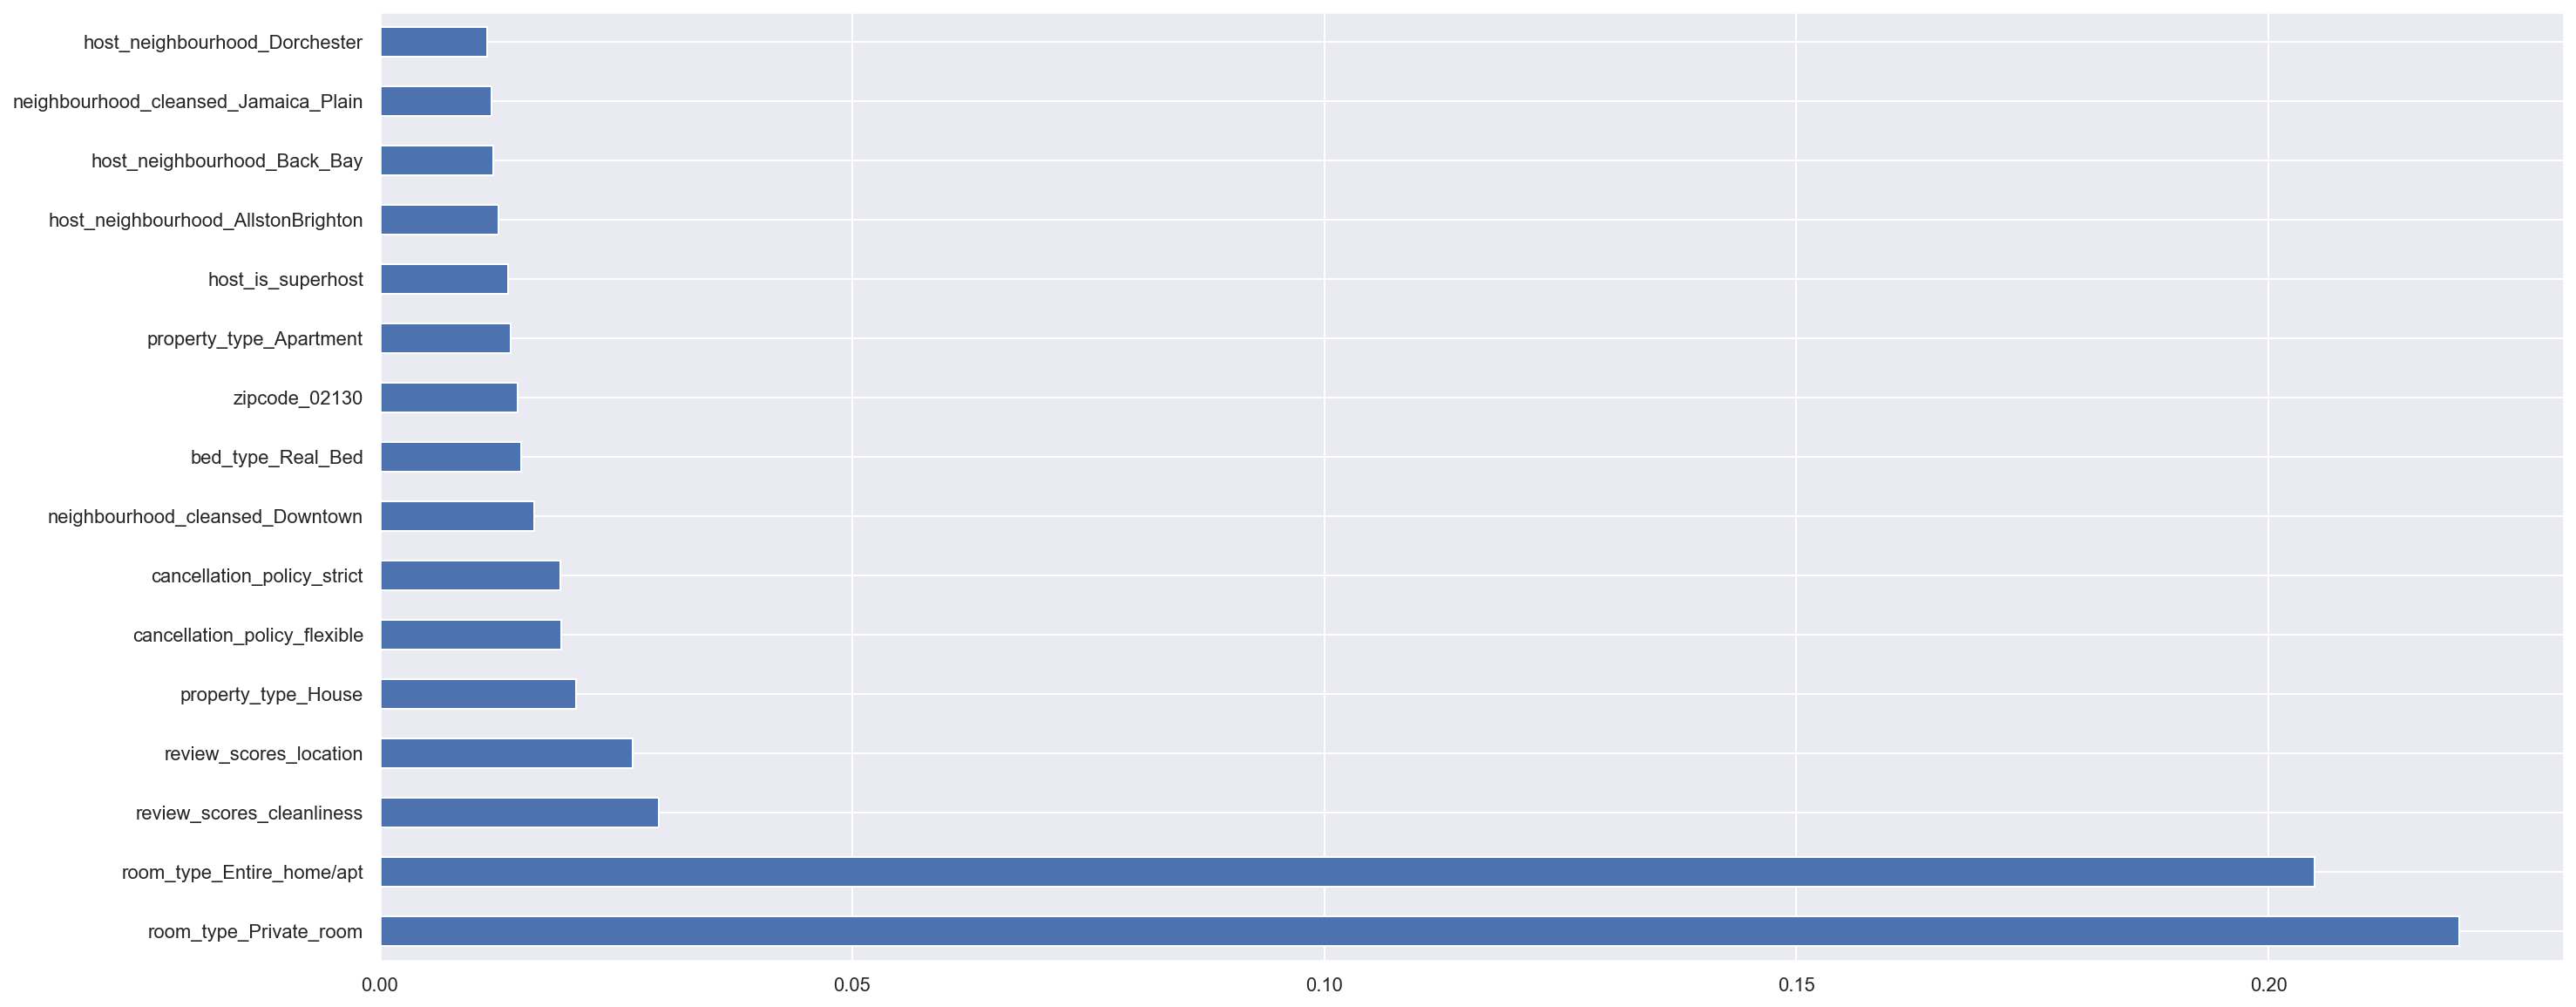

Top 20 Selected features: 
room_type_Private_room                  0.220227
room_type_Entire_home/apt               0.204908
review_scores_cleanliness               0.029529
review_scores_location                  0.026793
property_type_House                     0.020803
cancellation_policy_flexible            0.019206
cancellation_policy_strict              0.019136
neighbourhood_cleansed_Downtown         0.016312
bed_type_Real_Bed                       0.014972
zipcode_02130                           0.014570
property_type_Apartment                 0.013830
host_is_superhost                       0.013563
host_neighbourhood_AllstonBrighton      0.012520
host_neighbourhood_Back_Bay             0.011965
neighbourhood_cleansed_Jamaica_Plain    0.011769
host_neighbourhood_Dorchester           0.011359
require_guest_phone_verification        0.010960
cancellation_policy_moderate            0.010578
instant_bookable                        0.010276
zipcode_02116                           0.

In [25]:
# Begin the feature selection by RandomForest
feat_importances = rf_feature_selection(optimized_rf, X, y, cross_v=5)

In [26]:
selected_feats = feat_selection_percentage(X, feat_importances, threshold = 0.99)
selected_feats.head()

,room_type_Private_room,room_type_Entire_home/apt,review_scores_cleanliness,review_scores_location,property_type_House,cancellation_policy_flexible,cancellation_policy_strict,neighbourhood_cleansed_Downtown,bed_type_Real_Bed,zipcode_02130,property_type_Apartment,host_is_superhost,host_neighbourhood_AllstonBrighton,host_neighbourhood_Back_Bay,neighbourhood_cleansed_Jamaica_Plain,host_neighbourhood_Dorchester,require_guest_phone_verification,cancellation_policy_moderate,instant_bookable,zipcode_02116,zipcode_02111,cancellation_policy_superstrict30,neighbourhood_cleansed_Allston,zipcode_02131,host_neighbourhood_Jamaica_Plain,room_type_Shared_room,zipcode_02134,property_type_Condominium,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_South_End,neighbourhood_cleansed_Back_Bay,host_neighbourhood_Downtown_Crossing,neighbourhood_cleansed_Beacon_Hill,host_neighbourhood_South_Boston,zipcode_02114,host_neighbourhood_South_End,host_neighbourhood_West_End,zipcode_02109,host_neighbourhood_Beacon_Hill,host_neighbourhood_Financial_District,zipcode_02210,host_neighbourhood_North_End,neighbourhood_cleansed_Chinatown,zipcode_02128,review_scores_checkin,zipcode_02118,host_neighbourhood_Roslindale,zipcode_02135,zipcode_02129,host_neighbourhood_Charlestown,zipcode_02127,zipcode_02113,neighbourhood_cleansed_Brighton,zipcode_02125,zipcode_02108,host_neighbourhood_Mission_Hill,neighbourhood_cleansed_South_Boston_Waterfront,require_guest_profile_picture,neighbourhood_cleansed_East_Boston,is_location_exact,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_South_Boston,zipcode_02110,zipcode_02215,neighbourhood_cleansed_North_End,neighbourhood_cleansed_Charlestown,zipcode_02115,host_neighbourhood_Somerville,property_type_Townhouse,zipcode_02124,host_neighbourhood_Fenway/Kenmore,host_neighbourhood_Bernal_Heights,host_neighbourhood_Roxbury,host_neighbourhood_Theater_District,neighbourhood_cleansed_Mission_Hill,neighbourhood_cleansed_Roxbury,bed_type_Futon,host_neighbourhood_Cambridge,property_type_Boat,property_type_Loft,bed_type_Airbed,review_scores_communication,host_neighbourhood_East_Boston,bed_type_Pullout_Sofa,zipcode_02119,zipcode_02120,neighbourhood_cleansed_Bay_Village,host_neighbourhood_Chinatown,zipcode_02121,zipcode_02122,neighbourhood_cleansed_West_Roxbury,neighbourhood_cleansed_West_End,host_neighbourhood_Gay_Village,host_neighbourhood_West_Roxbury,neighbourhood_cleansed_Fenway,host_neighbourhood_Mattapan,zipcode_02132
0,1,0,9.0,9.0,0,0,0,0,1,0,1,False,0,0,0,0,False,1,True,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,0,1,0,0,0,0,0,0,0,0,0,0,False,0,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,9.0,9.0,0,0,0,0,1,0,1,True,0,0,0,0,False,1,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,0,1,0,0,0,0,0,0,0,0,0,0,True,0,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,10.0,9.0,1,1,0,0,1,0,0,True,0,0,0,0,False,0,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,0,1,0,0,0,0,0,0,0,0,0,0,False,0,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,10.0,9.0,0,1,0,0,1,0,0,True,0,0,0,0,False,0,False,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,0,1,0,0,0,0,0,0,0,0,0,0,False,0,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,10.0,9.0,0,0,1,0,1,0,1,False,0,0,0,0,False,0,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,0,1,0,0,0,0,0,0,0,0,0,0,False,0,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Predict

In [27]:
#Split into train and test
X_train,X_test,y_train,y_test = train_test_split(selected_feats, y, test_size=0.2, random_state=42) 

### Training model

In [28]:
optimized_rf = rf_best_para(X_train, y_train, 5)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 882 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1152 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1458 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1800 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  2.7min finished


{'bootstrap': True, 'max_depth': 22, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300, 'random_state': 42}


### Testing model

In [29]:
#Apply optimize hyperparameters to RF model
#Optimize RF Model Performance
print ('\nOptimize RF Model Performance')
best_rf = optimized_rf.best_estimator_
rf_accuracy = evaluate(best_rf, X_test, y_test)


Optimize RF Model Performance
Model Performance
Average Error: 33.6535 degrees.
Accuracy = 73.36%.


/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(<AxesSubplot:xlabel='price', ylabel='Density'>,
 <AxesSubplot:xlabel='price', ylabel='Density'>)

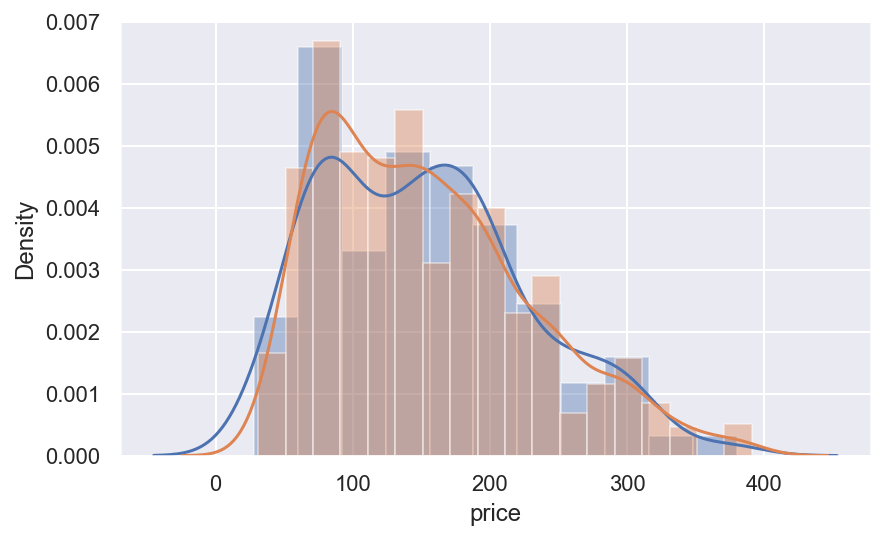

In [30]:
sns.distplot(y_test),sns.distplot(y_train)